In [1]:
import numpy as np
from scipy.signal import welch, spectrogram

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

# Load data

In [2]:
x = np.load('/gh/bv/misshapen/exampledata.npy')
Fs = 1000

# Functions to compute power spectral histogram

In [3]:
def compute_psd_hist(x, Fs, nperseg=None, noverlap=None, N_bins=None):
    if nperseg is None:
        nperseg = Fs
    if noverlap is None:
        noverlap = int(Fs/2)
    if N_bins is None:
        N_bins = 50
    
    # Compute windowed power spectra
    f, t, Sxx = spectrogram(x, fs=Fs, nperseg=nperseg, noverlap=noverlap)
    ps = np.transpose(np.log10(Sxx))
    
    # Limit psd to freq range of interest
    flim = [0, 100]
    ps = ps[:,np.logical_and(f >= flim[0], f < flim[1])]
    f = f[np.logical_and(f >= flim[0], f < flim[1])]
    
    # Prepare bins for power
    power_min = np.min(ps)
    power_max = np.max(ps)
    power_bins = np.linspace(power_min, power_max, N_bins+1)

    # Compute histogram of power for each frequency
    psd_hist = np.zeros((len(ps[0]), N_bins))
    for i in range(len(ps[0])):
        psd_hist[i], _ = np.histogram(ps[:,i], power_bins)
        psd_hist[i] = psd_hist[i]/sum(psd_hist[i])
    psd_hist = np.transpose(psd_hist)
    psd_hist = np.flipud(psd_hist)
    
    return t, f, power_bins, psd_hist, ps

In [4]:
def color2d(X, cmap=None, clim=None, cticks=None, interpolation='none', colorlabel=''):
    """Plot the matrix X using a 2-dimensional color matrix"""
    if cmap is None:
        cmap = cm.viridis
    if clim is None:
        clim = [None, None]
    if cticks is None:
        if clim is not None:
            cticks=clim
        
    # Plot colored matrix and colormap bar
    cax = plt.imshow(X, cmap=cmap, interpolation=interpolation,vmin=clim[0], vmax=clim[1])
    cbar = plt.colorbar(cax, ticks=cticks)
    
    # Format plot
    cbar.ax.set_yticklabels(cticks,size=15)
    cbar.ax.set_ylabel(colorlabel, size=20)
    plt.tight_layout()

def plot_psd_hist(f, power_bins, psd_hist, all_psds,
                  clim=None, cticks=None, 
                  power_ticks=None, f_tick_step=None,
                  colorlabel='Probability'):
    # Set default parameters
    if clim is None:
        clim = [0,.2]
    if cticks is None:
        cticks = np.arange(0,.21, .02)
    if power_ticks is None:
        power_ticks = np.arange(-5, 5.1,2)
    if f_tick_step is None:
        f_tick_step = 10
    
    plt.figure(figsize = (16,6))
    color2d(psd_hist, cmap=cm.viridis, clim=clim,
            cticks = cticks, colorlabel=colorlabel)

    # Decorate plot
    plt.title('Power spectral histogram', size=20)
    plt.xlabel('Frequency (Hz)', size=20)
    plt.ylabel('Log Power ($\mu V^2$/Hz)', size=20)

    # Compute the frequency axis
    N_f = len(f)
    xticks_idx = np.arange(0,N_f,f_tick_step)
    xticks_val = f[np.arange(0,N_f,f_tick_step)].astype(int)
    plt.xticks(xticks_idx, xticks_val, rotation='vertical', size=15)

    # Compute the power axis
    bin_idx = range(len(power_bins))
    bin_val = power_bins
    p_labels_idx = len(power_bins) - np.interp(power_ticks, bin_val, bin_idx)
    plt.yticks(p_labels_idx, power_ticks.astype(int), size=15)

    # Plot mean psd
    ps_mean = np.mean(all_psds,axis=0)
    mean_p_idx = len(power_bins) - np.interp(ps_mean, bin_val, bin_idx)
    plt.plot(f, mean_p_idx,'w')

# 2-line computation of power spectral histogram

In [5]:
t, f, power_bins, psd_hist, all_psds = compute_psd_hist(x, Fs)

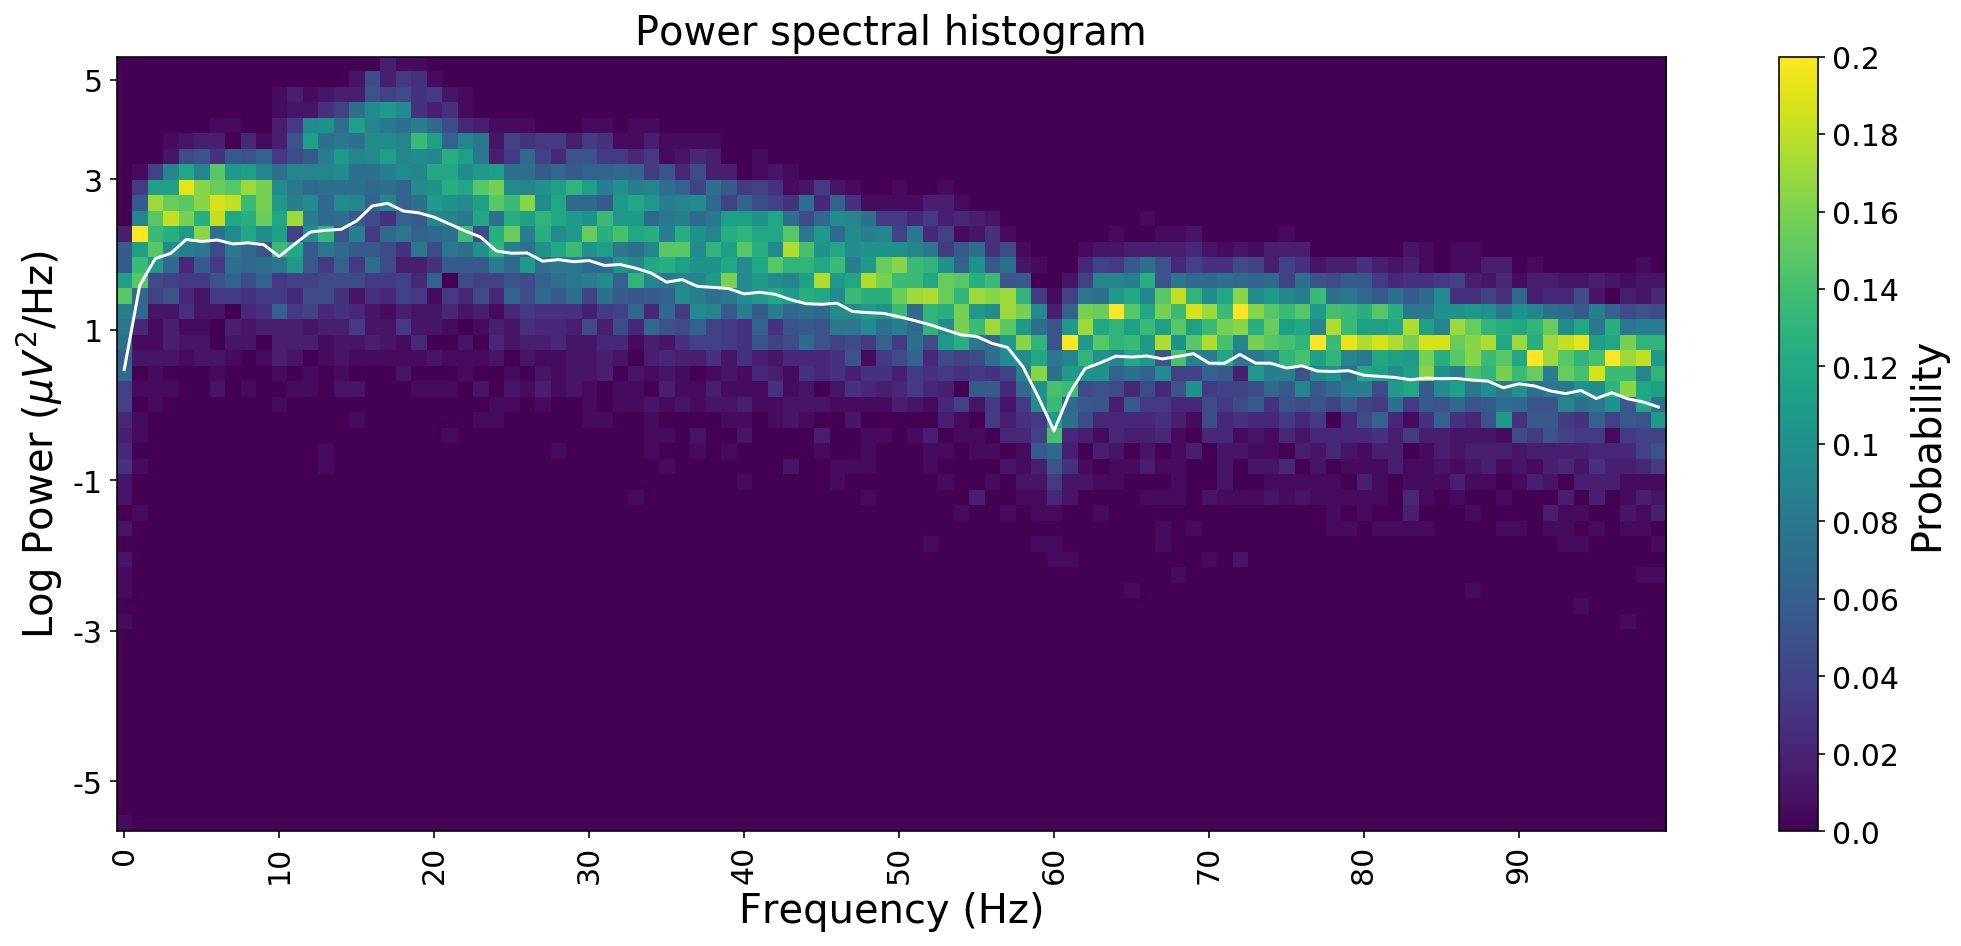

In [6]:
plot_psd_hist(f, power_bins, psd_hist, all_psds)

# All code below was for development

# Calculate individual window PSDs

In [7]:
noverlap = 500
nperseg = 1000

f, t, Sxx = spectrogram(x, fs=Fs, nperseg=nperseg, noverlap=noverlap)
ps = np.transpose(np.log10(Sxx))

# Limit f and psd

In [8]:
flim = [0, 100]
ps = ps[:,np.logical_and(f >= flim[0], f < flim[1])]
f = f[np.logical_and(f >= flim[0], f < flim[1])]


# Compute probability histogram across power

In [9]:
power_min = np.min(ps)
power_max = np.max(ps)
N_bins = 50
power_bins = np.linspace(power_min, power_max, N_bins+1)

psd_hist = np.zeros((len(ps[0]), N_bins))
for i in range(len(ps[0])):
    psd_hist[i], _ = np.histogram(ps[:,i], power_bins)
    psd_hist[i] = psd_hist[i]/sum(psd_hist[i])
psd_hist = np.transpose(psd_hist)
psd_hist = np.flipud(psd_hist)

# Visualize power spectrum histogram

In [10]:
# Transform power values to y-indices on the histogram plot
bin_idx = range(len(power_bins))
bin_val = power_bins

p_labels = np.arange(-5, 5.1,2)
p_labels_idx = N_bins - np.interp(p_labels, bin_val, bin_idx)

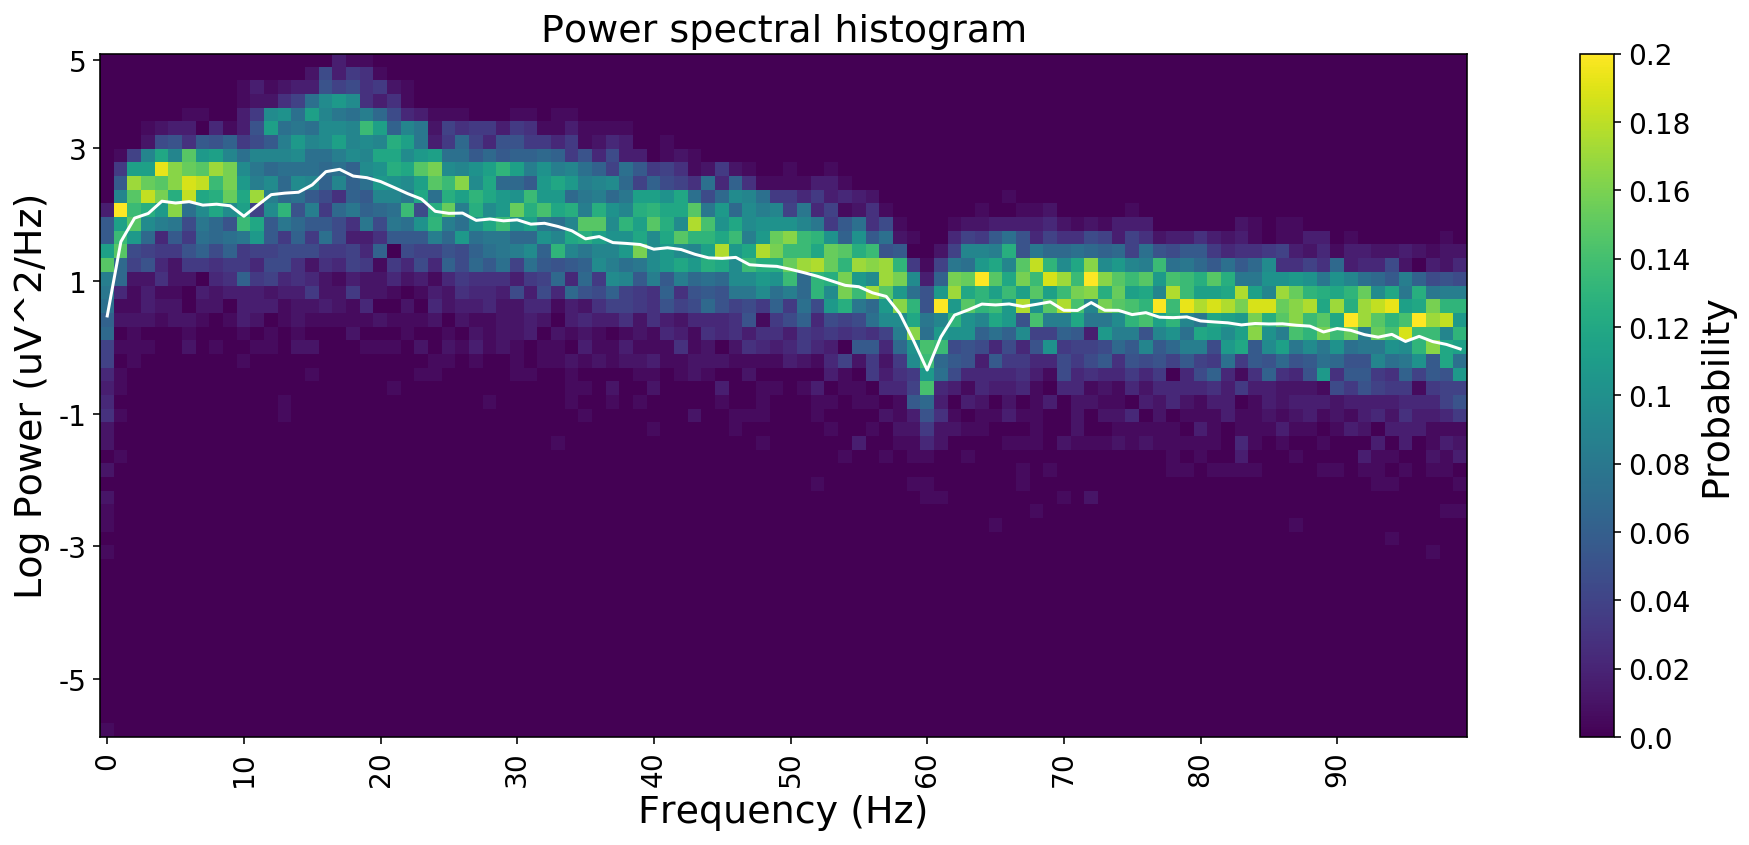

In [11]:
figsize = (16,6)
clim = [0,.2]
cticks = np.arange(0,.21, .02)
N_f = len(f)
power_ticks = np.arange(-5, 5.1,2)

plt.figure(figsize=figsize)

from tools.plt import color2d
color2d(psd_hist, cmap=cm.viridis, clim=clim, cticks = cticks, 
        color_label='Probability',
        plot_title='Power spectral histogram',
        plot_xlabel='Frequency (Hz)', plot_ylabel='Log Power (uV^2/Hz)',
        plot_xticks_locs=np.arange(0,N_f,10),
        plot_xticks_labels=f[np.arange(0,N_f,10)].astype(int),
        plot_yticks_locs=p_labels_idx,
        plot_yticks_labels=power_ticks.astype(int),
        interpolation='none', fontsize_minor=14, fontsize_major=19)

# Plot mean psd
ps_mean = np.mean(ps,axis=0)
mean_p_idx = N_bins - np.interp(ps_mean, bin_val, bin_idx)
plt.plot(f, mean_p_idx,'w')